In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
DATA_DIR = '/home/HDD6TB/datasets/emotions/ABAW/ABAW_8/ABAW-8th-BAH-train-data/'
VIDEO_DIR=DATA_DIR+'videos/'
FACES_DIR=DATA_DIR+'cropped-aligned-faces/'
AUDIO_DIR=DATA_DIR+'audios/'
TRANSCRIPTION_DIR=DATA_DIR+'transcription/'
TRAIN_LABELS=DATA_DIR+'default-split/train.txt'
VAL_LABELS=DATA_DIR+'default-split/val.txt'
ANNOTATION_FRAME_LABELS=DATA_DIR+'annotation.yml'

TEST_DATA_DIR = DATA_DIR+'ABAW-8th-BAH-test-data/'
TEST_VIDEO_DIR=TEST_DATA_DIR+'videos/'
TEST_AUDIO_DIR=TEST_DATA_DIR+'audios/'
TEST_FACES_DIR=TEST_DATA_DIR+'cropped-aligned-faces/'
TEST_TRANSCRIPTION_DIR=TEST_DATA_DIR+'transcription/'

In [3]:
import os
from PIL import Image
import cv2
import pathlib

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,precision_score, recall_score, accuracy_score, f1_score,roc_auc_score,average_precision_score

from collections import defaultdict
import os
import glob
import random
import numpy as np
from tqdm import tqdm
import time
import pickle
import pandas as pd
import random
import csv  
import matplotlib.pyplot as plt
import yaml


In [4]:
def get_names(id):
    name = ""
    if id>=0 and id<10:
        name = "0000" + str(id)
    elif id>=10 and id<100:
        name = "000" + str(id)
    elif id>=100 and id<1000:
        name = "00" + str(id)
    elif id>=1000 and id<10000:
        name = "0" + str(id)
    else:
        name = str(id)
    return name

In [5]:
compare_filenames=lambda x: int(os.path.splitext(x)[0].split('-')[1])

# Extract features

In [6]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

print(f"Torch: {torch.__version__}")
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

Torch: 2.0.1+cu118
True


In [7]:
if True:
    if True:
        model_name='mbf_va_mtl.pt'

        IMG_SIZE=112

        test_transforms = transforms.Compose(
        [
            transforms.Resize((112,112)),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
        ]
        )

        import sys
        sys.path.append("../../../emotiefflib/backbones/")
        import mobilefacenet
    else:
        if False:
            #model_name='affectnet_vggface2_enet2_gmp_smooth.pt'
            model_name='enet_b2_8_best.pt'
            #model_name='enet_b2_7.pt'
            IMG_SIZE=260 #224 #
        else:
            #model_name='affectnet_vggface2_enet0.pt'
            #model_name='affectnet_vggface2_enet0_new.pt'
            #model_name='enet_b0_7.pt'
            #model_name='enet_b0_8_best_afew.pt'
            #model_name='enet_b0_8_best_vgaf.pt'
            model_name='enet_b0_8_va_mtl.pt'
            #model_name='mobilevit_va_mtl.pt'

            IMG_SIZE=224

        #IMG_SIZE=112

        test_transforms = transforms.Compose(
            [
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                #transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
            ]
        )
        np_transforms = transforms.Compose(
            [
                transforms.ToPILImage(None),
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                #transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
            ]
        )


    print(model_name)
    feature_extractor_model = torch.load('../../../models/affectnet_emotions/'+model_name)

else:
    IMG_SIZE=112
    
    test_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])  
    
    import sys
    DDAMNFN_PATH='/home/avsavchenko/src/distr/DDAMFN'
    sys.path.append(DDAMNFN_PATH)
    from networks.DDAM import DDAMNet

    if False:
        feature_extractor_model = DDAMNet(num_class=8, num_head=2)
        model_name='affectnet8_epoch4_acc0.6462'
    else:
        feature_extractor_model = DDAMNet(num_class=10, num_head=2)
        model_name='affectnet8_epoch9_acc0.642_mtl_2'
    feature_extractor_model.load_state_dict(torch.load(DDAMNFN_PATH+'/checkpoints/'+model_name+'.pth')['model_state_dict'])
    feature_extractor_model.bn=torch.nn.Identity()
    print(model_name)

mbf_va_mtl.pt


In [8]:
feature_extractor_model

Sequential(
  (features): MobileFaceNet(
    (layers): ModuleList(
      (0): ConvBlock(
        (layers): Sequential(
          (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters=128)
        )
      )
      (1): ConvBlock(
        (layers): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters=128)
        )
      )
      (2): DepthWise(
        (layers): Sequential(
          (0): ConvBlock(
            (layers): Sequential(
              (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): PReLU(

In [9]:
if False:
    classifier_weights=feature_extractor_model.classifier[0].weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.classifier[0].bias.cpu().data.numpy()
elif False:
    classifier_weights=feature_extractor_model.classifier.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.classifier.bias.cpu().data.numpy()
elif False:
    classifier_weights=feature_extractor_model.head.fc.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.head.fc.bias.cpu().data.numpy()
else:
    classifier_weights=feature_extractor_model.fc.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.fc.bias.cpu().data.numpy()
print(classifier_weights.shape,classifier_weights)
print(classifier_bias.shape,classifier_bias)

(10, 512) [[-0.15847237 -0.0082755  -0.05878411 ... -0.13720182 -0.00222744
  -0.04625763]
 [ 0.1631905   0.00305371 -0.0400276  ...  0.04419322  0.07971639
   0.02389675]
 [-0.21113051 -0.00105867 -0.01162707 ... -0.18978879 -0.08599198
   0.00453433]
 ...
 [ 0.08492246 -0.03406343  0.03888768 ...  0.12722547 -0.0013511
   0.09250897]
 [-0.02396181  0.01268015  0.09095795 ... -0.01691812 -0.06352246
   0.06685334]
 [-0.06165804  0.01331687  0.02941979 ... -0.00387448  0.03024477
  -0.00236978]]
(10,) [-0.13135104  0.4276935  -0.5028847  -0.40331903  0.56353503  0.45924348
 -0.16013703  0.10144855  0.16608728  0.13354424]


In [10]:
if False:
    feature_extractor_model.classifier=torch.nn.Identity()
elif False:
    feature_extractor_model.head.fc=torch.nn.Identity()
else:
    feature_extractor_model.fc=torch.nn.Identity()
feature_extractor_model=feature_extractor_model.to(device)
feature_extractor_model.eval()

Sequential(
  (features): MobileFaceNet(
    (layers): ModuleList(
      (0): ConvBlock(
        (layers): Sequential(
          (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters=128)
        )
      )
      (1): ConvBlock(
        (layers): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters=128)
        )
      )
      (2): DepthWise(
        (layers): Sequential(
          (0): ConvBlock(
            (layers): Sequential(
              (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): PReLU(

In [11]:
def get_probab(features):
    x=np.dot(features,np.transpose(classifier_weights))+classifier_bias
    return x

In [ ]:
print(test_transforms)
data_dir=FACES_DIR
print(data_dir)

videoname2features,videoname2scores,videoname2img_names={},{},{}
for subject in tqdm(sorted(os.listdir(data_dir))):
    subject_dir=os.path.join(data_dir,subject)   
    for visit_name in sorted(os.listdir(subject_dir)):
        visit_dir=os.path.join(subject_dir,visit_name)   
        for question_name in sorted(os.listdir(visit_dir)):
            question_dir=os.path.join(visit_dir,question_name)   
            
            videoname=subject+'/'+visit_name+'/'+question_name
            #print(videoname)

            X_features,img_names=[],[]
            imgs=[]
            for img_name in sorted(os.listdir(question_dir), key=compare_filenames):#[::5]:
                #print(video_dir,img_name)
                img = Image.open(os.path.join(question_dir,img_name))
                img_tensor = test_transforms(img)
                if img.size:
                    img_names.append(videoname+'/'+img_name)
                    imgs.append(img_tensor)
                    if len(imgs)>=64: #48: #96: #32:        
                        #features,_,_ = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                        features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                        features=features.data.cpu().numpy()
                        #print(features.shape)

                        if len(X_features)==0:
                            X_features=features
                        else:
                            X_features=np.concatenate((X_features,features),axis=0)
                        imgs=[]

            if len(imgs)>0:        
                #features,_,_ = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                features=features.data.cpu().numpy()

                if len(X_features)==0:
                    X_features=features
                else:
                    X_features=np.concatenate((X_features,features),axis=0)

                imgs=[]
            if len(X_features)>0:
                X_scores=get_probab(X_features)
                #print(X_features.shape,X_scores.shape)
                videoname2features[videoname]=X_features
                videoname2scores[videoname]=X_scores
                videoname2img_names[videoname]=img_names

Compose(
    Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
/home/HDD6TB/datasets/emotions/ABAW/ABAW_8/ABAW-8th-BAH-train-data/cropped-aligned-faces/


  0%|          | 0/84 [00:00<?, ?it/s]

In [14]:
print(test_transforms)
data_dir=TEST_FACES_DIR
print(data_dir)

videoname2features_test,videoname2scores_test,videoname2img_names_test={},{},{}
for subject in tqdm(sorted(os.listdir(data_dir))):
    subject_dir=os.path.join(data_dir,subject)   
    for visit_name in sorted(os.listdir(subject_dir)):
        visit_dir=os.path.join(subject_dir,visit_name)   
        for question_name in sorted(os.listdir(visit_dir)):
            question_dir=os.path.join(visit_dir,question_name)   
            
            videoname=subject+'/'+visit_name+'/'+question_name
            #print(videoname)

            X_features,img_names=[],[]
            imgs=[]
            for img_name in sorted(os.listdir(question_dir), key=compare_filenames):#[::5]:
                #print(video_dir,img_name)
                img = Image.open(os.path.join(question_dir,img_name))
                img_tensor = test_transforms(img)
                if img.size:
                    img_names.append(videoname+'/'+img_name)
                    imgs.append(img_tensor)
                    if len(imgs)>=64: #48: #96: #32:        
                        #features,_,_ = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                        features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                        features=features.data.cpu().numpy()
                        #print(features.shape)

                        if len(X_features)==0:
                            X_features=features
                        else:
                            X_features=np.concatenate((X_features,features),axis=0)
                        imgs=[]

            if len(imgs)>0:        
                #features,_,_ = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                features=features.data.cpu().numpy()

                if len(X_features)==0:
                    X_features=features
                else:
                    X_features=np.concatenate((X_features,features),axis=0)

                imgs=[]
            if len(X_features)>0:
                X_scores=get_probab(X_features)
                #print(X_features.shape,X_scores.shape)
                videoname2features_test[videoname]=X_features
                videoname2scores_test[videoname]=X_scores
                videoname2img_names_test[videoname]=img_names

Compose(
    Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
/home/HDD6TB/datasets/emotions/ABAW/ABAW_8/ABAW-8th-BAH-train-data/ABAW-8th-BAH-test-data/cropped-aligned-faces/


  0%|          | 0/40 [00:00<?, ?it/s]

In [16]:
print(X_features.shape,X_scores.shape)

(1109, 512) (1109, 10)


### Save/load features 

In [6]:
import pickle
if False:
    #model_name='enet_b2_8_best'
    model_name='enet_b0_8_best_vgaf'
    #model_name='ddamfnet_8'
    has_va=False
else:
    #model_name='enet_b0_8_va_mtl'
    #model_name='mobilevit_va_mtl'
    model_name='mbf_va'
    #model_name='ddamfnet_mtl'
    has_va=True
    
MODEL2FEATURES='bah_'+model_name+'_aligned.pickle' 
#MODEL2FEATURES='bah_ddamfnet_mtl_aligned.pickle'
#MODEL2FEATURES='bah_mbf_va_aligned.pickle'
#MODEL2FEATURES='bah_mobilevit_va_mtl_aligned.pickle'

print(MODEL2FEATURES)

bah_mbf_va_aligned.pickle


In [ ]:
if False:
    with open(MODEL2FEATURES, 'wb') as handle:
        pickle.dump([videoname2features,videoname2scores,videoname2img_names], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
filename=MODEL2FEATURES
with open(filename, 'rb') as handle:
    videoname2features,videoname2scores,videoname2img_names=pickle.load(handle)

video_name='82734/Visite_1/82734_Question_5_2024-11-20_16-15-41_Video.mp4'
print(len(videoname2features),videoname2features[video_name].shape,videoname2scores[video_name].shape)

431 (928, 512) (928, 10)


In [8]:
MODEL2FEATURES_TEST='test_'+MODEL2FEATURES
print(MODEL2FEATURES_TEST)
if False:
    with open(MODEL2FEATURES_TEST, 'wb') as handle:
        pickle.dump([videoname2features_test,videoname2scores_test,videoname2img_names_test], handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(MODEL2FEATURES_TEST, 'rb') as handle:
        videoname2features_test,videoname2scores_test,videoname2img_names_test=pickle.load(handle)
print(len(videoname2features_test),len(videoname2scores_test),len(videoname2img_names_test))


test_bah_mbf_va_aligned.pickle
280 280 280


In [76]:
filename='eri_test_'+model_name+'_orig_faces.pickle'
print(filename)
with open(filename, 'rb') as handle:
    videoname2features_test,videoname2scores_test=pickle.load(handle)
print(len(videoname2features_test),videoname2features_test['12660'].shape,videoname2scores_test['12660'].shape)

eri_test_ddamfnet_mtl_orig_faces.pickle
4586 (39, 512) (39, 10)


### Audio

In [161]:
import wave, struct
from fnmatch import fnmatch
for subject in tqdm(sorted(os.listdir(VIDEO_DIR))):
    subject_dir=os.path.join(VIDEO_DIR,subject)   
    for visit_name in sorted(os.listdir(subject_dir)):
        visit_dir=os.path.join(subject_dir,visit_name)   
        audio_dir=AUDIO_DIR+subject+'/'+visit_name+'/'
        if not os.path.exists(audio_dir):
            os.makedirs(audio_dir)
        for question_name in sorted(os.listdir(visit_dir)):
            video_path=os.path.join(visit_dir,question_name)   
            waveFile=audio_dir+question_name+'.wav'
            command = "ffmpeg -i '"+video_path+"' -ac 1 -ar 16000 -vn '"+waveFile+"'"
            #print(command)
            os.system(command=command)

100%|██████████| 84/84 [01:04<00:00,  1.30it/s]


In [20]:
import wave, struct
from fnmatch import fnmatch
for subject in tqdm(sorted(os.listdir(TEST_VIDEO_DIR))):
    subject_dir=os.path.join(TEST_VIDEO_DIR,subject)   
    for visit_name in sorted(os.listdir(subject_dir)):
        visit_dir=os.path.join(subject_dir,visit_name)   
        audio_dir=TEST_AUDIO_DIR+subject+'/'+visit_name+'/'
        if not os.path.exists(audio_dir):
            os.makedirs(audio_dir)
        for question_name in sorted(os.listdir(visit_dir)):
            video_path=os.path.join(visit_dir,question_name)   
            waveFile=audio_dir+question_name+'.wav'
            command = "ffmpeg -i '"+video_path+"' -ac 1 -ar 16000 -vn '"+waveFile+"'"
            #print(command)
            os.system(command=command)

  0%|          | 0/40 [00:00<?, ?it/s]

In [21]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model,AutoProcessor, HubertModel
import torchaudio
import torch

In [22]:
if False:
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
    model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
else:
    processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
    model = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft")
model.eval()

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


HubertModel(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertLayerNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (1-4): 4 x HubertLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (5-6): 2 x HubertLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): HubertFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=True)
    (dropout): Dropout(p=

In [10]:
videoname2audio_features={}
for subject in tqdm(sorted(os.listdir(VIDEO_DIR))):
    subject_dir=os.path.join(VIDEO_DIR,subject)   
    for visit_name in sorted(os.listdir(subject_dir)):
        visit_dir=os.path.join(subject_dir,visit_name)
        audio_dir=AUDIO_DIR+subject+'/'+visit_name+'/'
        for question_name in sorted(os.listdir(visit_dir)):
            videoname=subject+'/'+visit_name+'/'+question_name
            waveFile=audio_dir+question_name+'.wav'
            array, fs = torchaudio.load(waveFile)
            inp = processor(array.squeeze(), sampling_rate=fs, return_tensors="pt")
            with torch.no_grad():
                outputs = model(**inp)
            videoname2audio_features[videoname]=outputs.last_hidden_state.numpy()[0]
    #print(videoname2audio_features[videoname].shape)

100%|██████████| 84/84 [15:21<00:00, 10.97s/it]


In [9]:
#MODEL2AUDIOFEATURES='bah_wav2vec2.pickle'
MODEL2AUDIOFEATURES='bah_hubert.pickle'

if False:
    with open(MODEL2AUDIOFEATURES, 'wb') as handle:
        pickle.dump(videoname2audio_features, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(MODEL2AUDIOFEATURES, 'rb') as handle:
        videoname2audio_features=pickle.load(handle)
print(len(videoname2audio_features))

433


In [19]:
from scipy.interpolate import interp1d
videoname2audio_features_sampled={}
for videoname in videoname2img_names:
    audio_embs=videoname2audio_features[videoname]
    x = np.linspace(0, 1, audio_embs.shape[0])
    f = interp1d(x, audio_embs,axis=0)
    new_x=np.linspace(0, 1, len(videoname2img_names[videoname]))
    videoname2audio_features_sampled[videoname]=f(new_x)
    print(len(videoname2img_names[videoname]),videoname2audio_features_sampled[videoname].shape)

482 (482, 1024)
730 (730, 1024)
835 (835, 1024)
610 (610, 1024)
681 (681, 1024)
1115 (1115, 1024)
721 (721, 1024)
389 (389, 1024)
646 (646, 1024)
420 (420, 1024)
465 (465, 1024)
370 (370, 1024)
433 (433, 1024)
339 (339, 1024)
349 (349, 1024)
477 (477, 1024)
801 (801, 1024)
572 (572, 1024)
290 (290, 1024)
306 (306, 1024)
285 (285, 1024)
320 (320, 1024)
467 (467, 1024)
417 (417, 1024)
513 (513, 1024)
610 (610, 1024)
546 (546, 1024)
554 (554, 1024)
331 (331, 1024)
659 (659, 1024)
761 (761, 1024)
672 (672, 1024)
1236 (1236, 1024)
858 (858, 1024)
1121 (1121, 1024)
806 (806, 1024)
1408 (1408, 1024)
953 (953, 1024)
930 (930, 1024)
908 (908, 1024)
801 (801, 1024)
1391 (1391, 1024)
748 (748, 1024)
493 (493, 1024)
561 (561, 1024)
484 (484, 1024)
384 (384, 1024)
399 (399, 1024)
930 (930, 1024)
504 (504, 1024)
914 (914, 1024)
922 (922, 1024)
327 (327, 1024)
524 (524, 1024)
925 (925, 1024)
247 (247, 1024)
147 (147, 1024)
283 (283, 1024)
213 (213, 1024)
215 (215, 1024)
307 (307, 1024)
635 (635, 1024

In [23]:
videoname2audio_features_test={}
for subject in tqdm(sorted(os.listdir(TEST_VIDEO_DIR))):
    subject_dir=os.path.join(TEST_VIDEO_DIR,subject)   
    for visit_name in sorted(os.listdir(subject_dir)):
        visit_dir=os.path.join(subject_dir,visit_name)
        audio_dir=TEST_AUDIO_DIR+subject+'/'+visit_name+'/'
        for question_name in sorted(os.listdir(visit_dir)):
            videoname=subject+'/'+visit_name+'/'+question_name
            waveFile=audio_dir+question_name+'.wav'
            array, fs = torchaudio.load(waveFile)
            inp = processor(array.squeeze(), sampling_rate=fs, return_tensors="pt")
            with torch.no_grad():
                outputs = model(**inp)
            videoname2audio_features_test[videoname]=outputs.last_hidden_state.numpy()[0]
    #print(videoname2audio_features_test[videoname].shape)

  0%|          | 0/40 [00:00<?, ?it/s]

In [10]:
#MODEL2AUDIOFEATURES_TEST='test_bah_wav2vec2.pickle'
MODEL2AUDIOFEATURES_TEST='test_bah_hubert.pickle'

if False:
    with open(MODEL2AUDIOFEATURES_TEST, 'wb') as handle:
        pickle.dump(videoname2audio_features_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(MODEL2AUDIOFEATURES_TEST, 'rb') as handle:
        videoname2audio_features_test=pickle.load(handle)
print(len(videoname2audio_features_test))

280


In [20]:
from scipy.interpolate import interp1d
videoname2audio_features_sampled_test={}
for videoname in videoname2img_names_test:
    audio_embs=videoname2audio_features_test[videoname]
    x = np.linspace(0, 1, audio_embs.shape[0])
    f = interp1d(x, audio_embs,axis=0)
    new_x=np.linspace(0, 1, len(videoname2img_names_test[videoname]))
    videoname2audio_features_sampled_test[videoname]=f(new_x)
    print(len(videoname2img_names_test[videoname]),videoname2audio_features_sampled_test[videoname].shape)

418 (418, 1024)
421 (421, 1024)
348 (348, 1024)
368 (368, 1024)
248 (248, 1024)
475 (475, 1024)
349 (349, 1024)
938 (938, 1024)
1220 (1220, 1024)
1238 (1238, 1024)
1053 (1053, 1024)
884 (884, 1024)
1765 (1765, 1024)
1064 (1064, 1024)
855 (855, 1024)
502 (502, 1024)
488 (488, 1024)
630 (630, 1024)
429 (429, 1024)
558 (558, 1024)
420 (420, 1024)
467 (467, 1024)
985 (985, 1024)
1119 (1119, 1024)
827 (827, 1024)
1267 (1267, 1024)
635 (635, 1024)
1118 (1118, 1024)
439 (439, 1024)
873 (873, 1024)
816 (816, 1024)
1079 (1079, 1024)
361 (361, 1024)
420 (420, 1024)
600 (600, 1024)
451 (451, 1024)
341 (341, 1024)
255 (255, 1024)
384 (384, 1024)
285 (285, 1024)
181 (181, 1024)
270 (270, 1024)
371 (371, 1024)
320 (320, 1024)
396 (396, 1024)
421 (421, 1024)
298 (298, 1024)
438 (438, 1024)
409 (409, 1024)
249 (249, 1024)
386 (386, 1024)
207 (207, 1024)
248 (248, 1024)
158 (158, 1024)
254 (254, 1024)
346 (346, 1024)
411 (411, 1024)
569 (569, 1024)
498 (498, 1024)
440 (440, 1024)
394 (394, 1024)
672 (6

### Text 

In [37]:
videoname2text={}
for subject in tqdm(sorted(os.listdir(TRANSCRIPTION_DIR))):
    subject_dir=os.path.join(TRANSCRIPTION_DIR,subject)   
    for visit_name in sorted(os.listdir(subject_dir)):
        visit_dir=os.path.join(subject_dir,visit_name)   
        for question_name in sorted(os.listdir(visit_dir)):
            question_dir=os.path.join(visit_dir,question_name)   
            
            videoname=subject+'/'+visit_name+'/'+question_name
            with open(question_dir+'/'+question_name.replace('.mp4','.yml'), 'r') as f:
                transcr = yaml.load(f)

            videoname2text[videoname]=transcr['text']
            

  0%|          | 0/84 [00:00<?, ?it/s]<ipython-input-37-8b0f0115b24f>:11: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  transcr = yaml.load(f)
100%|██████████| 84/84 [00:01<00:00, 47.39it/s]


In [11]:
AUDIO2TEXTS='bah_text.pickle'

if False:
    with open(AUDIO2TEXTS, 'wb') as handle:
        pickle.dump(videoname2text, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(AUDIO2TEXTS, 'rb') as handle:
        videoname2text=pickle.load(handle)
print(len(videoname2text),videoname2text['82596/Visite_1/82596_Question_1_2024-10-30_21-43-58_Video.mp4'])

431  I usually get out of bed, then brush my teeth, then have breakfast with coffee.


In [6]:
videoname2text_test={}
for subject in tqdm(sorted(os.listdir(TEST_TRANSCRIPTION_DIR))):
    subject_dir=os.path.join(TEST_TRANSCRIPTION_DIR,subject)   
    for visit_name in sorted(os.listdir(subject_dir)):
        visit_dir=os.path.join(subject_dir,visit_name)   
        for question_name in sorted(os.listdir(visit_dir)):
            question_dir=os.path.join(visit_dir,question_name)   
            
            videoname=subject+'/'+visit_name+'/'+question_name
            with open(question_dir+'/'+question_name.replace('.mp4','.yml'), 'r') as f:
                transcr = yaml.load(f)

            videoname2text_test[videoname]=transcr['text']
            

  0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-6-d281e465ee23>:11: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  transcr = yaml.load(f)
100%|██████████| 40/40 [00:03<00:00, 12.80it/s]


In [12]:
AUDIO2TEXTS_TEST='test_bah_text.pickle'

if False:
    with open(AUDIO2TEXTS_TEST, 'wb') as handle:
        pickle.dump(videoname2text_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(AUDIO2TEXTS_TEST, 'rb') as handle:
        videoname2text_test=pickle.load(handle)
print(len(videoname2text_test))

280


#### Feature extraction 

In [27]:
from transformers import pipeline
model_path="SamLowe/roberta-base-go_emotions"
classifier = pipeline(task="feature-extraction", model=model_path, tokenizer=model_path, max_length=512, truncation=True)


Some weights of RobertaModel were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
text_embeddings_list=[]
sentences=[]
for videoname in tqdm(videoname2text):
    sentences.append(videoname2text[videoname])
    if len(sentences)>32:
        outputs=classifier(sentences, return_tensors="pt")
        for output in outputs:
            text_embeddings_list.append(output[0].numpy())
        sentences=[]
        #break
if len(sentences)>0:
    outputs=classifier(sentences, return_tensors="pt")
    for output in outputs:
        text_embeddings_list.append(output[0].numpy())
    sentences=[]

100%|██████████| 431/431 [00:19<00:00, 21.83it/s]


In [131]:
from sentence_transformers import SentenceTransformer
#model_name='distilroberta-base'
model_name='all-MiniLM-L6-v1'
#model_name='intfloat/e5-base-v2'
model_st = SentenceTransformer(model_name)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [132]:
text_embeddings_list=[]
sentences=[]
for videoname in tqdm(videoname2text):
    sentences.append(videoname2text[videoname])
    if len(sentences)>32:
        outputs=model_st.encode(sentences)
        for output in outputs:
            text_embeddings_list.append(output)
        sentences=[]
        #break
if len(sentences)>0:
    outputs=model_st.encode(sentences)
    for output in outputs:
        text_embeddings_list.append(output)
    sentences=[]
#print(text_embeddings_list[0].shape,text_embeddings_list[1].shape)

100%|██████████| 431/431 [00:00<00:00, 1094.00it/s]


In [40]:
#text_embeddings_list[2].shape
text_embeddings={}
for i,videoname in enumerate(videoname2text):
    text_embeddings[videoname]=text_embeddings_list[i]

In [13]:
AUDIO2TEXT_EMBEDDINGS='bah_text_roberta-base-go_emotions.pickle'
#AUDIO2TEXT_EMBEDDINGS='bah_text_openai_small.pickle'
#AUDIO2TEXT_EMBEDDINGS='bah_text_gigachat.pickle'

if False:
    with open(AUDIO2TEXT_EMBEDDINGS, 'wb') as handle:
        pickle.dump(text_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(AUDIO2TEXT_EMBEDDINGS, 'rb') as handle:
        text_embeddings=pickle.load(handle)
print(len(text_embeddings),text_embeddings['82596/Visite_1/82596_Question_1_2024-10-30_21-43-58_Video.mp4'].shape)

431 (20, 768)


In [13]:
for videoname in videoname2AH_val:
    frame2ind={}
    for ind,frame in enumerate(videoname2img_names[videoname]):
        frame2ind[frame]=ind
    text_embs=text_embeddings[videoname]
    audio_embs=videoname2audio_features[videoname]
    print(len(videoname2img_names[videoname]),len(frame2ind),text_embs.shape,len(frame2ind)/text_embs.shape[0],audio_embs.shape,audio_embs.shape[0]/len(frame2ind))
    

1318 1318 (191, 768) 6.900523560209424 (2740, 1024) 2.078907435508346
1652 1652 (228, 768) 7.245614035087719 (3439, 1024) 2.081719128329298
1692 1692 (272, 768) 6.220588235294118 (3519, 1024) 2.0797872340425534
1433 1433 (207, 768) 6.9227053140096615 (2982, 1024) 2.0809490579204466
1146 1146 (207, 768) 5.536231884057971 (2382, 1024) 2.0785340314136125
1866 1866 (287, 768) 6.501742160278746 (3856, 1024) 2.0664523043944265
1767 1767 (314, 768) 5.627388535031847 (3676, 1024) 2.080362195812111
197 197 (20, 768) 9.85 (411, 1024) 2.0862944162436547
315 315 (38, 768) 8.289473684210526 (654, 1024) 2.0761904761904764
450 450 (50, 768) 9.0 (936, 1024) 2.08
122 122 (13, 768) 9.384615384615385 (256, 1024) 2.098360655737705
222 222 (24, 768) 9.25 (462, 1024) 2.081081081081081
262 262 (29, 768) 9.03448275862069 (545, 1024) 2.0801526717557253
141 141 (16, 768) 8.8125 (291, 1024) 2.0638297872340425
720 720 (92, 768) 7.826086956521739 (1503, 1024) 2.0875
896 896 (144, 768) 6.222222222222222 (1866, 1024

In [15]:
from scipy.interpolate import interp1d
videoname2text_features_sampled={}
for videoname in videoname2img_names:
    text_embs=text_embeddings[videoname]
    x = np.linspace(0, 1, text_embs.shape[0])
    f = interp1d(x, text_embs,axis=0)
    new_x=np.linspace(0, 1, len(videoname2img_names[videoname]))
    videoname2text_features_sampled[videoname]=f(new_x)
    print(len(videoname2img_names[videoname]),videoname2text_features_sampled[videoname].shape)

482 (482, 768)
730 (730, 768)
835 (835, 768)
610 (610, 768)
681 (681, 768)
1115 (1115, 768)
721 (721, 768)
389 (389, 768)
646 (646, 768)
420 (420, 768)
465 (465, 768)
370 (370, 768)
433 (433, 768)
339 (339, 768)
349 (349, 768)
477 (477, 768)
801 (801, 768)
572 (572, 768)
290 (290, 768)
306 (306, 768)
285 (285, 768)
320 (320, 768)
467 (467, 768)
417 (417, 768)
513 (513, 768)
610 (610, 768)
546 (546, 768)
554 (554, 768)
331 (331, 768)
659 (659, 768)
761 (761, 768)
672 (672, 768)
1236 (1236, 768)
858 (858, 768)
1121 (1121, 768)
806 (806, 768)
1408 (1408, 768)
953 (953, 768)
930 (930, 768)
908 (908, 768)
801 (801, 768)
1391 (1391, 768)
748 (748, 768)
493 (493, 768)
561 (561, 768)
484 (484, 768)
384 (384, 768)
399 (399, 768)
930 (930, 768)
504 (504, 768)
914 (914, 768)
922 (922, 768)
327 (327, 768)
524 (524, 768)
925 (925, 768)
247 (247, 768)
147 (147, 768)
283 (283, 768)
213 (213, 768)
215 (215, 768)
307 (307, 768)
635 (635, 768)
815 (815, 768)
582 (582, 768)
522 (522, 768)
587 (587, 768)


----------

In [28]:
text_embeddings_list=[]
sentences=[]
for videoname in tqdm(videoname2text_test):
    sentences.append(videoname2text_test[videoname])
    if len(sentences)>32:
        outputs=classifier(sentences, return_tensors="pt")
        for output in outputs:
            text_embeddings_list.append(output[0].numpy())
        sentences=[]
        #break
if len(sentences)>0:
    outputs=classifier(sentences, return_tensors="pt")
    for output in outputs:
        text_embeddings_list.append(output[0].numpy())
    sentences=[]
    
text_embeddings_test={}
for i,videoname in enumerate(videoname2text_test):
    text_embeddings_test[videoname]=text_embeddings_list[i]

  0%|          | 0/280 [00:00<?, ?it/s]

In [16]:
AUDIO2TEXT_EMBEDDINGS_TEST='test_bah_text_roberta-base-go_emotions.pickle'
#AUDIO2TEXT_EMBEDDINGS='test_bah_text_openai_small.pickle'
#AUDIO2TEXT_EMBEDDINGS='test_bah_text_gigachat.pickle'

if False:
    with open(AUDIO2TEXT_EMBEDDINGS_TEST, 'wb') as handle:
        pickle.dump(text_embeddings_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(AUDIO2TEXT_EMBEDDINGS_TEST, 'rb') as handle:
        text_embeddings_test=pickle.load(handle)
print(len(text_embeddings_test))

280


In [18]:
from scipy.interpolate import interp1d
videoname2text_features_sampled_test={}
for videoname in videoname2img_names_test:
    text_embs=text_embeddings_test[videoname]
    x = np.linspace(0, 1, text_embs.shape[0])
    f = interp1d(x, text_embs,axis=0)
    new_x=np.linspace(0, 1, len(videoname2img_names_test[videoname]))
    videoname2text_features_sampled_test[videoname]=f(new_x)
    print(len(videoname2img_names_test[videoname]),videoname2text_features_sampled_test[videoname].shape)

418 (418, 768)
421 (421, 768)
348 (348, 768)
368 (368, 768)
248 (248, 768)
475 (475, 768)
349 (349, 768)
938 (938, 768)
1220 (1220, 768)
1238 (1238, 768)
1053 (1053, 768)
884 (884, 768)
1765 (1765, 768)
1064 (1064, 768)
855 (855, 768)
502 (502, 768)
488 (488, 768)
630 (630, 768)
429 (429, 768)
558 (558, 768)
420 (420, 768)
467 (467, 768)
985 (985, 768)
1119 (1119, 768)
827 (827, 768)
1267 (1267, 768)
635 (635, 768)
1118 (1118, 768)
439 (439, 768)
873 (873, 768)
816 (816, 768)
1079 (1079, 768)
361 (361, 768)
420 (420, 768)
600 (600, 768)
451 (451, 768)
341 (341, 768)
255 (255, 768)
384 (384, 768)
285 (285, 768)
181 (181, 768)
270 (270, 768)
371 (371, 768)
320 (320, 768)
396 (396, 768)
421 (421, 768)
298 (298, 768)
438 (438, 768)
409 (409, 768)
249 (249, 768)
386 (386, 768)
207 (207, 768)
248 (248, 768)
158 (158, 768)
254 (254, 768)
346 (346, 768)
411 (411, 768)
569 (569, 768)
498 (498, 768)
440 (440, 768)
394 (394, 768)
672 (672, 768)
354 (354, 768)
505 (505, 768)
165 (165, 768)
205 (20

# Preprocess data

In [21]:
with open(ANNOTATION_FRAME_LABELS, 'r') as f:
    content = yaml.safe_load(f)

In [18]:
content['82557/Visite 1/82557_Question_1_2024-08-22 14-46-11_Video.mp4'].keys(),len(content)

(dict_keys(['fr_detailed_ah', 'frame_annotation', 'global_ah', 'time_detailed_ah']),
 431)

In [22]:
def get_videonames(filename):
    videoname2AH={}
    with open(os.path.join(DATA_DIR,filename)) as f:
        lines = f.read().splitlines()
        for line in lines:
            splitted_line=line.split(',')
            videoname=splitted_line[0]
            target=int(splitted_line[1])
            videoname2AH[videoname]=target
    print(len(videoname2AH))
    return videoname2AH
                
videoname2AH_train=get_videonames(TRAIN_LABELS)
videoname2AH_val=get_videonames(VAL_LABELS)

304
127


In [140]:
def get_video2targets(videoname2features,videoname2AH,step=1):
    X,y=[],[]
    for videoname in videoname2AH:
        frame2ind={}
        for ind,frame in enumerate(videoname2img_names[videoname]):
            frame2ind[frame]=ind
        features=videoname2features[videoname]
        for frame,AH in content[videoname]['frame_annotation']:
            ind=frame2ind[frame]
            if AH==1 or ind%step==0:
                X.append(features[ind])
                y.append(AH)
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape)
    return X,y

if False:
    X_val,y_val=get_video2targets(videoname2audio_features_sampled,videoname2AH_val,step=1)
    X_train,y_train=get_video2targets(videoname2audio_features_sampled,videoname2AH_train,step=1)
elif True:
    X_val,y_val=get_video2targets(videoname2text_features_sampled,videoname2AH_val,step=1)
    X_train,y_train=get_video2targets(videoname2text_features_sampled,videoname2AH_train,step=1)
elif False:
    X_val,y_val=get_video2targets(videoname2features,videoname2AH_val,step=1)
    X_train,y_train=get_video2targets(videoname2features,videoname2AH_train,step=1) #4)
else:
    X_val,y_val=get_video2targets(videoname2scores,videoname2AH_val,step=1)
    X_train,y_train=get_video2targets(videoname2scores,videoname2AH_train,step=1) #4)


(89600, 768) (89600,)
(205926, 768) (205926,)


In [40]:
def get_text2targets(videoname2AH,step=1):
    X,y=[],[]
    for videoname in videoname2AH:
        frame2ind={}
        for ind,frame in enumerate(videoname2img_names[videoname]):
            frame2ind[frame]=ind
        text_embs=text_embeddings[videoname]
        for frame,AH in content[videoname]['frame_annotation']:
            if AH==1 or ind%step==0:
                X.append(text_embs)
                y.append(AH)
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape)
    return X,y

X_val,y_val=get_text2targets(videoname2AH_val,step=1)
X_train,y_train=get_text2targets(videoname2AH_train,step=4)

(89600, 1536) (89600,)
(80730, 1536) (80730,)


In [99]:
def get_concat_features2targets(videoname2AH,step=1):
    X,y=[],[]
    for videoname in videoname2AH:
        frame2ind={}
        for ind,frame in enumerate(videoname2img_names[videoname]):
            frame2ind[frame]=ind
        video_features=videoname2scores[videoname]
        #text_embs=text_embeddings[videoname]
        text_embs=text_embeddings[videoname].mean(axis=0)
        audio_features=videoname2audio_features_sampled[videoname]
        text_features=videoname2text_features_sampled[videoname]
        for frame,AH in content[videoname]['frame_annotation']:
            ind=frame2ind[frame]
            if AH==1 or ind%step==0:
                #X.append(np.concatenate((video_features[ind],text_embs),axis=0))
                
                #X.append(np.concatenate((video_features[ind],text_features[ind]),axis=0))
                #X.append(video_features[ind])
                #X.append(audio_features[ind])
                #X.append(np.concatenate((video_features[ind],audio_features[ind]),axis=0))
                X.append(np.concatenate((video_features[ind],audio_features[ind],text_embs),axis=0))
                #X.append(np.concatenate((audio_features[ind],text_embs),axis=0))
                #X.append(np.concatenate((video_features[ind],audio_features[ind],text_features[ind]),axis=0))
                
                y.append(AH)
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape)
    return X,y

X_val,y_val=get_concat_features2targets(videoname2AH_val,step=1)
X_train,y_train=get_concat_features2targets(videoname2AH_train,step=1) #4)

(89600, 1802) (89600,)
(205926, 1802) (205926,)


In [141]:
if True:
    TRAIN_VAL=True
    X_train=np.concatenate((X_train,X_val))
    y_train=np.concatenate((y_train,y_val))
    print(X_train.shape,y_train.shape)

(295526, 768) (295526,)


#### Explore data

Text(0.5, 1.0, '(val)')

<Figure size 216x216 with 0 Axes>

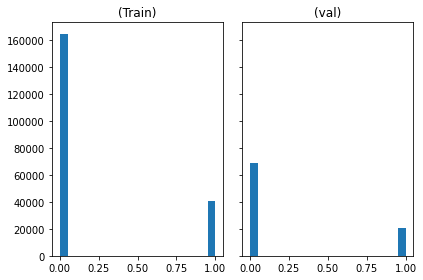

In [26]:
plt.figure(figsize=(3, 3))
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(y_train, bins=20)
axs[0].set_title('(Train)')
axs[1].hist(y_val, bins=20)
axs[1].set_title('(val)')

# Learning

In [16]:
np.random.seed(1)
res=RandomForestClassifier(n_estimators=1000,max_depth=3, n_jobs=-1)
#res=svm.LinearSVC(C=1)
#import xgboost as xgb
#res=xgb.XGBRegressor(n_estimators=10)
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

res.fit(X_train, y_train)
y_val_preds = res.predict(X_val)
print(y_val_preds.shape)
print(f1_score(y_val,y_val_preds,average='weighted'))

(89600,)
0.674065070583054


In [17]:
y_val_preds = res.predict_proba(X_val)
print(y_val_preds.shape)
for t in np.linspace(0,0.9,10):
    new_pred = (y_val_preds[:,1] >= t)
    print(t,f1_score(y_val,new_pred,average='weighted'))

(89600, 2)
0.0 0.08397536141640863
0.1 0.23923699613906446
0.2 0.615172904729874
0.30000000000000004 0.7061321512010741
0.4 0.674065070583054
0.5 0.674065070583054
0.6000000000000001 0.674065070583054
0.7000000000000001 0.674065070583054
0.8 0.674065070583054
0.9 0.674065070583054


--------

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential, load_model,model_from_json
from tensorflow.keras.applications import mobilenet,mobilenet_v2,densenet,inception_resnet_v2,inception_v3,vgg16,resnet_v2,resnet
import efficientnet.tfkeras as enet
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D,Activation, Conv2D, Reshape,DepthwiseConv2D,Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, CSVLogger, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow.keras.backend as K 

print(tf.__version__)
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

2.13.1


In [25]:
from copy import deepcopy
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = deepcopy(self.model.get_weights())

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = deepcopy(self.model.get_weights())

In [26]:
from sklearn.utils.class_weight import compute_class_weight
neg, pos = np.bincount(y_train)
print(neg, pos, neg/pos)
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weights={0:weight_for_0,1:weight_for_1}
#class_weights[i] = compute_class_weight('balanced', [0,1], y_train[:, i])
print(class_weights,compute_class_weight('balanced', [0,1], y_train))

165140 40786 4.0489383612023735
{0: 0.623489160712123, 1: 2.5244691806011867} [0.62348916 2.52446918]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0, 1], y=[1 1 1 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [27]:
def print_metrics():
    y_val_preds=mlpModel.predict(X_val,verbose=0)
    new_pred = (y_val_preds >= 0.5)
    print(f1_score(y_val,new_pred,average='weighted'))

In [28]:
if True:
    loss='binary_crossentropy'
    #loss='hinge'
else:
    import tensorflow.keras.backend as K
    def get_weighted_loss(weights):
        def weighted_loss(y_true, y_pred):
            y_true=tf.cast(y_true, tf.float32)
            ce=K.binary_crossentropy(y_true, y_pred)
            return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*ce, axis=-1)
        return weighted_loss
    loss=get_weighted_loss(class_weights)

In [29]:
from tensorflow.keras import backend as K
def relu_advanced(x):
    return K.relu(x, max_value=1)

In [30]:
#metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()] # 
metrics=[tf.keras.metrics.F1Score(average='weighted',threshold=0.5)]

In [142]:
batch_size=512 #256 #128 #1024 #
mlpModel=Sequential()
mlpModel.add(Dense(64, input_shape=X_train.shape[1:],activation='relu')) #256
mlpModel.add(Dense(1,activation='sigmoid'))
    
mlpModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss='binary_crossentropy', metrics=metrics)
mlpModel.summary()

import gc
gc.collect()

#save_best_model = SaveBestModel('val_loss',False)
save_best_model = SaveBestModel('val_f1_score',True)

#num_epochs=20
num_epochs=1
mlpModel.fit(X_train,y_train.astype(np.float64), batch_size=batch_size, epochs=num_epochs, verbose=1, #class_weight=class_weights, 
             callbacks=[save_best_model], validation_data=(X_val,y_val.astype(np.float64)))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

print_metrics()
if True:
    print('Best weights:')
    mlpModel.set_weights(best_model_weights)
    print_metrics()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                49216     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 49281 (192.50 KB)
Trainable params: 49281 (192.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
578/578 [==============================] - 5s 7ms/step - loss: 0.4017 - f1_score: 0.3245 - val_loss: 0.3777 - val_f1_score: 0.5075
0.5075235962867737
0.7996352957419591
Best weights:
0.7996352957419591


In [82]:
batch_size=512 #128 #1024 #
mlpModel=Sequential()

mlpModel.add(Dense(1, input_shape=X_train.shape[1:],activation='sigmoid',use_bias=True,kernel_regularizer=tf.keras.regularizers.l2(1.0/batch_size)))
mlpModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=metrics)
mlpModel.summary()


import gc
gc.collect()

#save_best_model = SaveBestModel('val_loss',False)
save_best_model = SaveBestModel('val_f1_score',True)
mlpModel.fit(X_train,y_train.astype(np.float64), batch_size=batch_size, epochs=20, verbose=1, class_weight=class_weights, 
             callbacks=[save_best_model], validation_data=(X_val,y_val.astype(np.float64)))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

print_metrics()
if False:
    print('Best weights:')
    mlpModel.set_weights(best_model_weights)
    print_metrics()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1)                 769       
                                                                 
Total params: 769 (3.00 KB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
403/403 [==============================] - 3s 7ms/step - loss: 0.5802 - f1_score: 0.4509 - val_loss: 0.6719 - val_f1_score: 0.3777
Epoch 2/20
403/403 [==============================] - 3s 6ms/step - loss: 0.5262 - f1_score: 0.5283 - val_loss: 0.6998 - val_f1_score: 0.3861
Epoch 3/20
403/403 [==============================] - 3s 6ms/step - loss: 0.5091 - f1_score: 0.5457 - val_loss: 0.6780 - val_f1_score: 0.3824
Epoch 4/20
403/403 [==============================] - 3s 6ms/step - loss: 0.5000 - f1_score: 0.5559 - val_loss: 0.6902 - val_f

In [85]:
y_val_preds=mlpModel.predict(X_val,verbose=0)
for t in np.linspace(0,0.9,10):
    new_pred = (y_val_preds >= t)
    print(t,f1_score(y_val,new_pred,average='weighted'))

0.0 0.08397536141640863
0.1 0.47818043113162284
0.2 0.5937707749469368
0.30000000000000004 0.6714925215524378
0.4 0.7037931223320123
0.5 0.714730699552383
0.6000000000000001 0.7052262021275646
0.7000000000000001 0.6927716785650124
0.8 0.6860486898017749
0.9 0.6763623541686223


enet_mtl

mlp
scores
0.3 0.683270404865019
0.5 0.674065070583054

features
0.5 0.6845600415252329

mbf_va
scores
0.3 0.69998378811507
0.5 0.6745209202464137

features
0.5 0.6835512457339219

1 layer: scores 0.6 0.7058534273480211


ddamfnet_mtl
scores
0.3 0.6876002129077958
0.5 0.6740540926333174

features
0.5 0.6743391260484833
0.7 0.6801708851799948

mobilevit_va_mtl
scores
0.3 0.6980500110920965
0.5 0.6740916339997399

features
0.5 0.6769258209353625


ddamfnet_8
scores
0.3 0.6797134586091566
0.5 0.6739780341817486

features
0.4 0.6835845096516041
0.5 0.6793618305662475

best_vgaf
scores
0.30000000000000004 0.6974543426153296
0.5 0.6744867540403574

features
0.5 0.664929612944537
0.6 0.6765722614182715


audio
hubert
1 hidden 0.5 0.6872779144415531


text
roberta


In [86]:
if True:
    #mlpModel.save_weights('bah_mbf_va_faces.h5')#0.3 0.7127118641781647 0.5 0.6809112817505317
    #mlpModel.save_weights('bah_audio.h5')#1 hidden 0.5 0.6872779144415531
    mlpModel.save_weights('bah_text.h5')#1 hidden 0.5 0.714730699552383
    #mlpModel.save_weights('bah_mbf_text_32.h5') #0.5 0.7225620550472124
else:
    mlpModel.load_weights('bah_mbf_va_faces.h5')
    #mlpModel.load_weights('bah_mbf_text_32.h5')
    #mlpModel.load_weights('bah_audio.h5')
    print_metrics()

In [143]:
if False:
    mlpModelFaces=mlpModel
    mlpModelFaces.save_weights('bah_mbf_va_faces_train_val.h5')
elif False:
    mlpModelAudio=mlpModel
    mlpModelAudio.save_weights('bah_audio_train_val.h5')
else:
    mlpModelText=mlpModel
    mlpModelText.save_weights('bah_text_train_val.h5')
    

In [65]:
mlpModelFaces=mlpModel
mlpModelFaces.load_weights('bah_mbf_va_faces.h5')


y_val_preds_video=mlpModelFaces.predict(X_val,verbose=0)
for t in np.linspace(0,0.9,10):
    new_pred = (y_val_preds_video >= t)
    print(t,f1_score(y_val,new_pred,average='weighted'))
    

print()
t=0.3
new_pred = (y_val_preds_video >= t)
print(t,f1_score(y_val,new_pred,average='weighted'))
confusion_matrix(y_val,new_pred)

0.0 0.08397536141640863
0.1 0.12755907473634462
0.2 0.5447434879474157
0.30000000000000004 0.7127118641781647
0.4 0.6953498597573039
0.5 0.6809112817505317
0.6000000000000001 0.6748963302010191
0.7000000000000001 0.6741923717911663
0.8 0.674065070583054
0.9 0.674065070583054

0.3 0.7127118641781647


array([[61959,  7304],
       [15971,  4366]])

In [71]:
mlpModelAudio=mlpModel
mlpModelAudio.load_weights('bah_audio.h5')

y_val_preds_audio=mlpModelAudio.predict(X_val,verbose=0)
for t in np.linspace(0,0.9,10):
    new_pred = (y_val_preds_audio >= t)
    print(t,f1_score(y_val,new_pred,average='weighted'))
    

print()

t=0.5 #0.3
new_pred = (y_val_preds_audio >= t)
print(t,f1_score(y_val,new_pred,average='weighted'))


confusion_matrix(y_val,new_pred)

0.0 0.08397536141640863
0.1 0.4339121318923602
0.2 0.5924394263106827
0.30000000000000004 0.6574224910817422
0.4 0.6818995536111505
0.5 0.6872779144415531
0.6000000000000001 0.6843098817662281
0.7000000000000001 0.6800358580075511
0.8 0.6764023252501593
0.9 0.6744735417514716

0.5 0.6872779144415531


array([[63514,  5749],
       [18069,  2268]])

In [87]:
mlpModelText=mlpModel
mlpModelText.load_weights('bah_text.h5')

y_val_preds_text=mlpModelText.predict(X_val,verbose=0)
for t in np.linspace(0,0.9,10):
    new_pred = (y_val_preds_text >= t)
    print(t,f1_score(y_val,new_pred,average='weighted'))
    

print()
t=0.5 #0.7 #0.4 #
new_pred = (y_val_preds_text >= t)
print(t,f1_score(y_val,new_pred,average='weighted'))

confusion_matrix(y_val,new_pred)

0.0 0.08397536141640863
0.1 0.47818043113162284
0.2 0.5937707749469368
0.30000000000000004 0.6714925215524378
0.4 0.7037931223320123
0.5 0.714730699552383
0.6000000000000001 0.7052262021275646
0.7000000000000001 0.6927716785650124
0.8 0.6860486898017749
0.9 0.6763623541686223

0.5 0.714730699552383


array([[61115,  8148],
       [15430,  4907]])

In [133]:
mlpModelFaces.summary()
mlpModelAudio.summary()
mlpModelText.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 769 (3.00 KB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                65600     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Tota

In [73]:
for w in np.linspace(0,1,11):
    y_ensemble=w*y_val_preds_video+(1-w)*y_val_preds_audio
    for t in [0.2,0.3,0.4,0.5,0.6,0.7]:
        new_pred = (y_ensemble >= t)
        print(w,t,f1_score(y_val,new_pred,average='weighted'))
    print()

0.0 0.2 0.587480577785225
0.0 0.3 0.6569651145071818
0.0 0.4 0.6824425648151644
0.0 0.5 0.6856844252254299
0.0 0.6 0.6818757902712668
0.0 0.7 0.6773774332689562

0.1 0.2 0.5866352081361769
0.1 0.3 0.6621055954531865
0.1 0.4 0.6846237978878268
0.1 0.5 0.6864310157122697
0.1 0.6 0.6801884047857105
0.1 0.7 0.6762063173837168

0.2 0.2 0.5852355501164277
0.2 0.3 0.6679271108064185
0.2 0.4 0.6869660639051194
0.2 0.5 0.6846713211307623
0.2 0.6 0.6780094133226198
0.2 0.7 0.6748705527918222

0.30000000000000004 0.2 0.5815778441052618
0.30000000000000004 0.3 0.6749608959012116
0.30000000000000004 0.4 0.6888255525260902
0.30000000000000004 0.5 0.6828946130495495
0.30000000000000004 0.6 0.6765117919574983
0.30000000000000004 0.7 0.6741785475584693

0.4 0.2 0.5757395805583204
0.4 0.3 0.6823738904851496
0.4 0.4 0.6902478566072876
0.4 0.5 0.6799106753359075
0.4 0.6 0.6749649310400466
0.4 0.7 0.6740595816427375

0.5 0.2 0.5668568115331333
0.5 0.3 0.6909951528355646
0.5 0.4 0.6898192162893245
0.5 0.5 0

In [67]:
for w in np.linspace(0,1,11):
    y_ensemble=w*y_val_preds_video+(1-w)*y_val_preds_text
    for t in [0.2,0.3,0.4,0.5,0.6, 0.7, 0.8]:
        new_pred = (y_ensemble >= t)
        print(w,t,f1_score(y_val,new_pred,average='weighted'))
    print()

0.0 0.2 0.6563537343739165
0.0 0.3 0.6766658920570345
0.0 0.4 0.6901012544128813
0.0 0.5 0.6986103073232967
0.0 0.6 0.7049053809039371
0.0 0.7 0.707307239042897
0.0 0.8 0.7089009531746576

0.1 0.2 0.656386512164705
0.1 0.3 0.6785344277149241
0.1 0.4 0.6924253868720476
0.1 0.5 0.701190819615141
0.1 0.6 0.7054778574802574
0.1 0.7 0.7084795507741691
0.1 0.8 0.7079378940105657

0.2 0.2 0.6560175454784098
0.2 0.3 0.6805119711223927
0.2 0.4 0.6949625532838505
0.2 0.5 0.7044676141806154
0.2 0.6 0.707515080458778
0.2 0.7 0.7099264235105053
0.2 0.8 0.6999159234952451

0.30000000000000004 0.2 0.655397038674081
0.30000000000000004 0.3 0.6833367432109794
0.30000000000000004 0.4 0.6982534745631517
0.30000000000000004 0.5 0.7055984992270606
0.30000000000000004 0.6 0.7091273553597373
0.30000000000000004 0.7 0.7075686728324977
0.30000000000000004 0.8 0.676301757034254

0.4 0.2 0.6545800138297471
0.4 0.3 0.6870061218281345
0.4 0.4 0.7019407593613565
0.4 0.5 0.7080901811535892
0.4 0.6 0.7105012529096078

In [89]:
#w1,w2=0.5,0.1
best_f1=0
best_w1,best_w2,best_t=0,0,0
for w1 in np.arange(0.0,0.95,0.05):
    for w2 in np.arange(0.0,1-w1,0.05):
        y_ensemble=w1*y_val_preds_video+w2*y_val_preds_audio+(1-w1-w2)*y_val_preds_text
        for t in [0.2,0.3,0.4,0.5,0.6, 0.7]:
            new_pred = (y_ensemble >= t)
            f1=f1_score(y_val,new_pred,average='weighted')
            #print(w1,w2,t,f1)
            if f1>best_f1:
                best_f1=f1
                best_w1,best_w2,best_t=w1,w2,t
        #print()

print(best_w1,best_w2,best_t,best_f1)

0.6000000000000001 0.15000000000000002 0.3 0.7203728655057625



0.6000000000000001 0.15000000000000002 0.3 0.7203728655057625

### Smoothing 

In [34]:
threshold=0.3
deltas=[0,5,10,20,30,40,50,60,70,80,100,150]

In [104]:
#v2f=videoname2features
v2f=videoname2scores
y_preds_all=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname in videoname2AH_val:
    frame2ind={}
    for ind,frame in enumerate(videoname2img_names[videoname]):
        frame2ind[frame]=ind
    features=v2f[videoname]
    #text_embs=text_embeddings[videoname]
    text_embs=text_embeddings[videoname].mean(axis=0)
    X=[]
    for frame,AH in content[videoname]['frame_annotation']:
        ind=frame2ind[frame]
        X.append(features[ind])
        #X.append(np.concatenate((features[ind],text_embs),axis=0))
        
    preds_proba=mlpModelFaces.predict(np.array(X),verbose=0)
    for hInd,delta in enumerate(deltas):
        for i in range(len(preds_proba)):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1])
            total_preds[hInd].append(proba)

for hInd,delta in enumerate(deltas):
    for t in [0.2, 0.3,0.4,0.5,0.6]:
        new_pred = (np.array(total_preds[hInd]) >= t)
        print(delta,t,f1_score(y_val,new_pred,average='weighted'))
    print()


0 0.2 0.5447434879474157
0 0.3 0.7127118641781647
0 0.4 0.6953498597573039
0 0.5 0.6809112817505317
0 0.6 0.6748963302010191

5 0.2 0.5253440435829675
5 0.3 0.717759717752158
5 0.4 0.6908892184512
5 0.5 0.6783720987936441
5 0.6 0.674065070583054

10 0.2 0.5165326407107852
10 0.3 0.7189470865686411
10 0.4 0.688465380735041
10 0.5 0.6762500197007377
10 0.6 0.674065070583054

20 0.2 0.5018621513187091
20 0.3 0.7201447996128214
20 0.4 0.6862859667979138
20 0.5 0.6741539086200914
20 0.6 0.674065070583054

30 0.2 0.49438398998486566
30 0.3 0.7169453316869716
30 0.4 0.6828421820724406
30 0.5 0.674065070583054
30 0.6 0.674065070583054

40 0.2 0.49110419044798626
40 0.3 0.7147305981671971
40 0.4 0.6799140794846165
40 0.5 0.674065070583054
40 0.6 0.674065070583054

50 0.2 0.48652714469653263
50 0.3 0.7116937973056899
50 0.4 0.6791216530923743
50 0.5 0.674065070583054
50 0.6 0.674065070583054

60 0.2 0.4834010739573934
60 0.3 0.7088239508318976
60 0.4 0.6780097854742909
60 0.5 0.674065070583054
6

In [74]:
v2f=videoname2audio_features_sampled
y_preds_all=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname in videoname2AH_val:
    frame2ind={}
    for ind,frame in enumerate(videoname2img_names[videoname]):
        frame2ind[frame]=ind
    features=v2f[videoname]
    X=[]
    for frame,AH in content[videoname]['frame_annotation']:
        ind=frame2ind[frame]
        X.append(features[ind])
        
    preds_proba=mlpModelAudio.predict(np.array(X),verbose=0)
    for hInd,delta in enumerate(deltas):
        for i in range(len(preds_proba)):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1])
            total_preds[hInd].append(proba)

for hInd,delta in enumerate(deltas):
    for t in [0.2, 0.3,0.4,0.5,0.6]:
        new_pred = (np.array(total_preds[hInd]) >= t)
        print(delta,t,f1_score(y_val,new_pred,average='weighted'))
    print()


0 0.2 0.5924394263106827
0 0.3 0.6574224910817422
0 0.4 0.6818995536111505
0 0.5 0.6872779144415531
0 0.6 0.6843098817662281

5 0.2 0.5691313579494216
5 0.3 0.6672737733384501
5 0.4 0.6912078796576778
5 0.5 0.6856026075754004
5 0.6 0.6763035613571524

10 0.2 0.5640511119883963
10 0.3 0.6714111297108663
10 0.4 0.6937870509553536
10 0.5 0.6830234265316478
10 0.6 0.6752082794234838

20 0.2 0.5610447271640767
20 0.3 0.6752359518357286
20 0.4 0.6937485265919809
20 0.5 0.6783462010689366
20 0.6 0.675221073002222

30 0.2 0.5599993859618337
30 0.3 0.6778842318816104
30 0.4 0.6931812918615786
30 0.5 0.6771025903432891
30 0.6 0.6753513594905264

40 0.2 0.5566574448905988
40 0.3 0.6804408505701344
40 0.4 0.6916701129129617
40 0.5 0.6773816675777979
40 0.6 0.674912343687706

50 0.2 0.552831701375408
50 0.3 0.68231721591337
50 0.4 0.6901996564661241
50 0.5 0.6773874147574255
50 0.6 0.6738303914333398

60 0.2 0.5491452155055914
60 0.3 0.6815486456969985
60 0.4 0.6900532471990092
60 0.5 0.67727257010

In [90]:
v2f=videoname2text_features_sampled
y_preds_all=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname in videoname2AH_val:
    frame2ind={}
    for ind,frame in enumerate(videoname2img_names[videoname]):
        frame2ind[frame]=ind
    features=v2f[videoname]
    X=[]
    for frame,AH in content[videoname]['frame_annotation']:
        ind=frame2ind[frame]
        X.append(features[ind])
        
    preds_proba=mlpModelText.predict(np.array(X),verbose=0)
    for hInd,delta in enumerate(deltas):
        for i in range(len(preds_proba)):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1])
            total_preds[hInd].append(proba)

for hInd,delta in enumerate(deltas):
    for t in [0.2, 0.3,0.4,0.5,0.6, 0.7]:
        new_pred = (np.array(total_preds[hInd]) >= t)
        print(delta,t,f1_score(y_val,new_pred,average='weighted'))
    print()


0 0.2 0.5937707749469368
0 0.3 0.6714925215524378
0 0.4 0.7037931223320123
0 0.5 0.714730699552383
0 0.6 0.7052262021275646
0 0.7 0.6927716785650124

5 0.2 0.5923886250386629
5 0.3 0.6716664484257954
5 0.4 0.7045945429352429
5 0.5 0.7158123795098356
5 0.6 0.7049206687359413
5 0.7 0.6929210101875034

10 0.2 0.5898066209168007
10 0.3 0.6730661099576316
10 0.4 0.7051044512943984
10 0.5 0.716358171699614
10 0.6 0.7038719044171992
10 0.7 0.6913243912999057

20 0.2 0.5863690177497561
20 0.3 0.6731615283326454
20 0.4 0.7044727065798922
20 0.5 0.7184856715129416
20 0.6 0.7049887359254762
20 0.7 0.6893615989755374

30 0.2 0.5859997964721212
30 0.3 0.6723389929087468
30 0.4 0.7068690442474534
30 0.5 0.7194189646609459
30 0.6 0.7020698359626825
30 0.7 0.6887736067745202

40 0.2 0.5868122013872408
40 0.3 0.6710150452817335
40 0.4 0.7094767434772875
40 0.5 0.7183343754285862
40 0.6 0.7002912874532367
40 0.7 0.6899763852804338

50 0.2 0.585873376269858
50 0.3 0.670129583819906
50 0.4 0.7105008988008

In [105]:
v2f=videoname2scores
y_preds_all=[]
total_preds=[[] for _ in range(len(deltas))]
best_w1,best_w2=0.6,0.15
for videoname in videoname2AH_val:
    frame2ind={}
    for ind,frame in enumerate(videoname2img_names[videoname]):
        frame2ind[frame]=ind
    video_features=videoname2scores[videoname]
    audio_features=videoname2audio_features_sampled[videoname]
    text_features=videoname2text_features_sampled[videoname]
    X_video, X_audio, X_text=[],[],[]
    for frame,AH in content[videoname]['frame_annotation']:
        ind=frame2ind[frame]
        X_video.append(video_features[ind])
        X_audio.append(audio_features[ind])
        X_text.append(text_features[ind])
        
    preds_proba_video=mlpModelFaces.predict(np.array(X_video),verbose=0)
    preds_proba_audio=mlpModelAudio.predict(np.array(X_audio),verbose=0)
    preds_proba_text=mlpModelText.predict(np.array(X_text),verbose=0)
    y_ensemble=best_w1*preds_proba_video+best_w2*preds_proba_audio+(1-best_w1-best_w2)*preds_proba_text
    for hInd,delta in enumerate(deltas):
        for i in range(len(y_ensemble)):
            i1=max(i-delta,0)
            proba=np.mean(y_ensemble[i1:i+delta+1])
            total_preds[hInd].append(proba)

for hInd,delta in enumerate(deltas):
    for t in [0.2,0.3,0.4,0.5,0.6,0.7]:
        new_pred = (np.array(total_preds[hInd]) >= t)
        print(delta,t,f1_score(y_val,new_pred,average='weighted'))
    print()


0 0.2 0.5494146363449106
0 0.3 0.7203728655057625
0 0.4 0.6968290348348019
0 0.5 0.6768083342781502
0 0.6 0.6742244189684848
0 0.7 0.674065070583054

5 0.2 0.5407562902521234
5 0.3 0.7239266403698255
5 0.4 0.6921089247413601
5 0.5 0.6753978695492906
5 0.6 0.674065070583054
5 0.7 0.674065070583054

10 0.2 0.5349881668811091
10 0.3 0.7266921820194996
10 0.4 0.6903031829266355
10 0.5 0.6746754879641583
10 0.6 0.674065070583054
10 0.7 0.674065070583054

20 0.2 0.5328460518731112
20 0.3 0.7255505990645987
20 0.4 0.6884670966684073
20 0.5 0.6741978662556116
20 0.6 0.674065070583054
20 0.7 0.674065070583054

30 0.2 0.5301124482127735
30 0.3 0.7250098198287933
30 0.4 0.6865440702811986
30 0.5 0.674065070583054
30 0.6 0.674065070583054
30 0.7 0.674065070583054

40 0.2 0.5282643827719866
40 0.3 0.7269462609718909
40 0.4 0.6873300620142411
40 0.5 0.674065070583054
40 0.6 0.674065070583054
40 0.7 0.674065070583054

50 0.2 0.5247548695173722
50 0.3 0.726539084019141
50 0.4 0.6869870387313755
50 0.5

In [100]:
y_val.shape,len(total_preds[hInd]),y_ensemble.shape,preds_proba_video.shape,preds_proba_audio.shape,preds_proba_text.shape

((89600,), 56769, (447, 1), (447, 1), (447, 1), (447, 1))

#### Global model 

In [111]:
def get_video2target(v2f,videoname2AH):
    X,y=[],[]
    for videoname in videoname2AH:
        frame2ind={}
        for ind,frame in enumerate(videoname2img_names[videoname]):
            frame2ind[frame]=ind
        features=v2f[videoname]
        cur_features=[]
        for frame,AH in content[videoname]['frame_annotation']:
            ind=frame2ind[frame]
            cur_features.append(features[ind])
        cur_features=np.array(cur_features)
        mean_features = (np.mean(cur_features, axis=0))
        std_features = (np.std(cur_features, axis=0))
        max_features = (np.max(cur_features, axis=0))
        min_features = (np.min(cur_features, axis=0))

        # join several features together
        feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None) 
        #feature=mean_features
        X.append(feature)
        y.append(videoname2AH[videoname])
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape)
    return X,y

if False:
    X_global_val,y_global_val=get_video2target(videoname2features,videoname2AH_val)
    X_global_train,y_global_train=get_video2target(videoname2features,videoname2AH_train)
elif False:
    X_global_val,y_global_val=get_video2target(videoname2scores,videoname2AH_val)
    X_global_train,y_global_train=get_video2target(videoname2scores,videoname2AH_train)
else:
    X_global_val,y_global_val=get_video2target(videoname2audio_features,videoname2AH_val)
    X_global_train,y_global_train=get_video2target(videoname2audio_features,videoname2AH_train)
    

(127, 4096) (127,)
(304, 4096) (304,)


In [116]:
def get_text2target(videoname2AH,embeddings):
    X,y=[],[]
    for videoname in videoname2AH:
        if False:
            X.append(embeddings[videoname])
        else:
            X.append(embeddings[videoname].mean(axis=0))
        y.append(videoname2AH[videoname])
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape)
    return X,y

if True:
    X_global_val,y_global_val=get_text2target(videoname2AH_val,text_embeddings)
    X_global_train,y_global_train=get_text2target(videoname2AH_train,text_embeddings)
else:
    X_global_val,y_global_val=get_text2target(videoname2AH_val,videoname2audio_features)
    X_global_train,y_global_train=get_text2target(videoname2AH_train,videoname2audio_features)


(127, 768) (127,)
(304, 768) (304,)


In [117]:
text_embeddings['82557/Visite 1/82557_Question_1_2024-08-22 14-46-11_Video.mp4'].shape

(61, 768)

In [118]:
X_global_train_norm=preprocessing.normalize(X_global_train,norm='l2')
X_global_val_norm=preprocessing.normalize(X_global_val,norm='l2')

In [119]:
clf = svm.LinearSVC(C=1,class_weight='balanced') 
#clf = svm.SVC(C=1.2,kernel='rbf',class_weight='balanced')

if True:    
    clf.fit(X_global_train_norm, y_global_train)
    y_global_pred = clf.predict(X_global_val_norm)
else:
    clf.fit(X_global_train, y_global_train)
    y_global_pred = clf.predict(X_global_val)
print("Accuracy:",np.mean(y_global_val==y_global_pred))

Accuracy: 0.7165354330708661


In [27]:
confusion_matrix(y_global_val,y_global_pred)

array([[35, 19],
       [23, 50]])

In [114]:
for C in np.linspace(0.1,4,40):
    clf = svm.LinearSVC(C=C,class_weight='balanced') 
    if True:    
        clf.fit(X_global_train_norm, y_global_train)
        y_global_pred = clf.predict(X_global_val_norm)
    else:
        clf.fit(X_global_train, y_global_train)
        y_global_pred = clf.predict(X_global_val)
    print(C,np.mean(y_global_val==y_global_pred))

0.1 0.6614173228346457
0.2 0.6771653543307087
0.3 0.6850393700787402
0.4 0.6850393700787402
0.5 0.6929133858267716
0.6 0.6850393700787402
0.7 0.6850393700787402
0.7999999999999999 0.6850393700787402
0.8999999999999999 0.6771653543307087
0.9999999999999999 0.6771653543307087
1.0999999999999999 0.6692913385826772
1.2 0.6692913385826772
1.3 0.6692913385826772
1.4 0.6692913385826772
1.5 0.6692913385826772
1.5999999999999999 0.6850393700787402
1.7 0.6850393700787402
1.8 0.6850393700787402
1.9 0.6850393700787402
2.0 0.6850393700787402
2.0999999999999996 0.6850393700787402
2.1999999999999997 0.6850393700787402
2.3 0.6850393700787402
2.4 0.6850393700787402
2.5 0.6850393700787402
2.6 0.6850393700787402
2.6999999999999997 0.6850393700787402
2.8 0.6850393700787402
2.9 0.6850393700787402
3.0 0.6850393700787402
3.0999999999999996 0.6850393700787402
3.1999999999999997 0.6771653543307087
3.3 0.6850393700787402
3.4 0.6850393700787402
3.5 0.6929133858267716
3.5999999999999996 0.6929133858267716
3.69999

In [120]:
for C in np.linspace(0.1,4,40):
    #clf = svm.LinearSVC(C=C,class_weight='balanced') 
    clf = svm.SVC(C=C,kernel='rbf',class_weight='balanced')
    if False:    
        clf.fit(X_global_train_norm, y_global_train)
        y_global_pred = clf.predict(X_global_val_norm)
    else:
        clf.fit(X_global_train, y_global_train)
        y_global_pred = clf.predict(X_global_val)
    print(C,np.mean(y_global_val==y_global_pred))

0.1 0.6535433070866141
0.2 0.6692913385826772
0.3 0.7086614173228346
0.4 0.7165354330708661
0.5 0.7165354330708661
0.6 0.7165354330708661
0.7 0.7480314960629921
0.7999999999999999 0.7480314960629921
0.8999999999999999 0.7480314960629921
0.9999999999999999 0.7559055118110236
1.0999999999999999 0.7716535433070866
1.2 0.7716535433070866
1.3 0.7559055118110236
1.4 0.7559055118110236
1.5 0.7559055118110236
1.5999999999999999 0.7480314960629921
1.7 0.7401574803149606
1.8 0.7322834645669292
1.9 0.7322834645669292
2.0 0.7165354330708661
2.0999999999999996 0.7007874015748031
2.1999999999999997 0.7007874015748031
2.3 0.6929133858267716
2.4 0.7007874015748031
2.5 0.7086614173228346
2.6 0.7007874015748031
2.6999999999999997 0.7007874015748031
2.8 0.7007874015748031
2.9 0.7007874015748031
3.0 0.7007874015748031
3.0999999999999996 0.7007874015748031
3.1999999999999997 0.7007874015748031
3.3 0.6929133858267716
3.4 0.6929133858267716
3.5 0.6929133858267716
3.5999999999999996 0.6929133858267716
3.69999

In [121]:
#clf = svm.LinearSVC(C=1,class_weight='balanced') 
clf = svm.SVC(C=1.1,kernel='rbf',class_weight='balanced')
if False:    
    clf.fit(X_global_train_norm, y_global_train)
    y_global_pred = clf.predict(X_global_val_norm)
else:
    clf.fit(X_global_train, y_global_train)
    y_global_pred = clf.predict(X_global_val)
print("Accuracy:",np.mean(y_global_val==y_global_pred), "F1:",f1_score(y_true=y_global_val,y_pred=y_global_pred, average="weighted"))
confusion_matrix(y_global_val,y_global_pred)


Accuracy: 0.7716535433070866 F1: 0.7713631924180372


array([[39, 15],
       [14, 59]])

In [144]:
if TRAIN_VAL:
    TRAIN_VAL=True
    X_global_all=np.concatenate((X_global_train,X_global_val))
    y_global_all=np.concatenate((y_global_train,y_global_val))
    print(X_global_all.shape,y_global_all.shape)

    clf = svm.SVC(C=1.1,kernel='rbf',class_weight='balanced')
    clf.fit(X_global_all, y_global_all)
    y_global_pred = clf.predict(X_global_val)
    print("Accuracy:",np.mean(y_global_val==y_global_pred), "F1:",f1_score(y_true=y_global_val,y_pred=y_global_pred, average="weighted"))
    confusion_matrix(y_global_val,y_global_pred)


(431, 768) (431,)
Accuracy: 0.7952755905511811 F1: 0.7960479411904499


In [123]:
#v2f=videoname2features
v2f=videoname2scores
total_preds=[[] for _ in range(len(deltas))]

for videoname in videoname2AH_val:
    frame2ind={}
    for ind,frame in enumerate(videoname2img_names[videoname]):
        frame2ind[frame]=ind
    features=v2f[videoname]
    #text_embs=text_embeddings[videoname]
    text_embs=text_embeddings[videoname].mean(axis=0)
    global_AH=clf.predict([text_embs])[0]
    X=[]
    for frame,AH in content[videoname]['frame_annotation']:
        ind=frame2ind[frame]
        X.append(features[ind])
        #X.append(np.concatenate((features[ind],text_embs),axis=0))
        
        
    preds_proba=mlpModelFaces.predict(np.array(X),verbose=0)
    for hInd,delta in enumerate(deltas):
        for i in range(len(preds_proba)):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1])
            if global_AH==0:
                proba=0
            total_preds[hInd].append(proba)
            

for hInd,delta in enumerate(deltas):
    for t in [0.2, 0.3,0.4,0.5,0.6]:
        new_pred = (np.array(total_preds[hInd]) >= t)
        print(delta,t,f1_score(y_val,new_pred,average='weighted'))
    print()


0 0.2 0.669449297761579
0 0.3 0.7206922005883483
0 0.4 0.6938581403535673
0 0.5 0.6807216079995162
0 0.6 0.6748753685941896

5 0.2 0.6611912640510336
5 0.3 0.7209018972302281
5 0.4 0.6897304975992095
5 0.5 0.6782404450654532
5 0.6 0.674065070583054

10 0.2 0.6571318538522992
10 0.3 0.7211785274063173
10 0.4 0.687517561750827
10 0.5 0.6763282877330855
10 0.6 0.674065070583054

20 0.2 0.6519277619505952
20 0.3 0.7197824642470669
20 0.4 0.684170430534739
20 0.5 0.6741539086200914
20 0.6 0.674065070583054

30 0.2 0.6500169427713312
30 0.3 0.7158727619497623
30 0.4 0.6809856058694501
30 0.5 0.674065070583054
30 0.6 0.674065070583054

40 0.2 0.6485636404001724
40 0.3 0.7136276678594953
40 0.4 0.6783449806315937
40 0.5 0.674065070583054
40 0.6 0.674065070583054

50 0.2 0.6456210468146547
50 0.3 0.7105147344001636
50 0.4 0.6784188941724052
50 0.5 0.674065070583054
50 0.6 0.674065070583054

60 0.2 0.6439890442689946
60 0.3 0.7091157417311046
60 0.4 0.6780097854742909
60 0.5 0.674065070583054
60

In [124]:
v2f=videoname2scores
y_preds_all=[]
total_preds=[[] for _ in range(len(deltas))]
best_w1,best_w2=0.6,0.15
for videoname in videoname2AH_val:
    frame2ind={}
    for ind,frame in enumerate(videoname2img_names[videoname]):
        frame2ind[frame]=ind
    
    text_embs=text_embeddings[videoname].mean(axis=0)
    global_AH=clf.predict([text_embs])[0]
    
    video_features=videoname2scores[videoname]
    audio_features=videoname2audio_features_sampled[videoname]
    text_features=videoname2text_features_sampled[videoname]
    X_video, X_audio, X_text=[],[],[]
    for frame,AH in content[videoname]['frame_annotation']:
        ind=frame2ind[frame]
        X_video.append(video_features[ind])
        X_audio.append(audio_features[ind])
        X_text.append(text_features[ind])
        
    preds_proba_video=mlpModelFaces.predict(np.array(X_video),verbose=0)
    preds_proba_audio=mlpModelAudio.predict(np.array(X_audio),verbose=0)
    preds_proba_text=mlpModelText.predict(np.array(X_text),verbose=0)
    y_ensemble=best_w1*preds_proba_video+best_w2*preds_proba_audio+(1-best_w1-best_w2)*preds_proba_text
    for hInd,delta in enumerate(deltas):
        for i in range(len(y_ensemble)):
            i1=max(i-delta,0)
            proba=np.mean(y_ensemble[i1:i+delta+1])
            if global_AH==0:
                proba=0
            total_preds[hInd].append(proba)

for hInd,delta in enumerate(deltas):
    for t in [0.2,0.3,0.4,0.5,0.6,0.7]:
        new_pred = (np.array(total_preds[hInd]) >= t)
        print(delta,t,f1_score(y_val,new_pred,average='weighted'))
    print()


0 0.2 0.6396827050351916
0 0.3 0.7260132081425393
0 0.4 0.6971369077680634
0 0.5 0.6768083342781502
0 0.6 0.6742244189684848
0 0.7 0.674065070583054

5 0.2 0.6313707218841565
5 0.3 0.727732307337362
5 0.4 0.6924127464977677
5 0.5 0.6753978695492906
5 0.6 0.674065070583054
5 0.7 0.674065070583054

10 0.2 0.6268135889210799
10 0.3 0.7300575035301405
10 0.4 0.6905900347362406
10 0.5 0.6746754879641583
10 0.6 0.674065070583054
10 0.7 0.674065070583054

20 0.2 0.6245487373913897
20 0.3 0.7283739429143603
20 0.4 0.6887125897202173
20 0.5 0.6741978662556116
20 0.6 0.674065070583054
20 0.7 0.674065070583054

30 0.2 0.6206014337151411
30 0.3 0.7273446683273185
30 0.4 0.6867056310880202
30 0.5 0.674065070583054
30 0.6 0.674065070583054
30 0.7 0.674065070583054

40 0.2 0.6197491440102847
40 0.3 0.7290357253536482
40 0.4 0.6873922546268629
40 0.5 0.674065070583054
40 0.6 0.674065070583054
40 0.7 0.674065070583054

50 0.2 0.6166659808810205
50 0.3 0.7287388104099725
50 0.4 0.6869870387313755
50 0.5

# Save test results 

In [60]:
with open(os.path.join(TEST_DATA_DIR,'submissions/trial-1.txt'),'r') as f:
    test_set_sample=f.read().splitlines()
print(len(test_set_sample),test_set_sample[:5])

test_set_videos=[]
for s in test_set_sample:
    videoname=os.path.dirname(s[:-2])
    if videoname not in test_set_videos:
        test_set_videos.append(videoname)
    
print(len(test_set_videos))

169479 ['82683/Visite_1/82683_Question_1_2024-11-14_09-21-32_Video.mp4/frame-0.jpg,0', '82683/Visite_1/82683_Question_1_2024-11-14_09-21-32_Video.mp4/frame-1.jpg,0', '82683/Visite_1/82683_Question_1_2024-11-14_09-21-32_Video.mp4/frame-2.jpg,0', '82683/Visite_1/82683_Question_1_2024-11-14_09-21-32_Video.mp4/frame-3.jpg,0', '82683/Visite_1/82683_Question_1_2024-11-14_09-21-32_Video.mp4/frame-4.jpg,0']
280


In [50]:
OUTDIR=os.path.join(TEST_DATA_DIR,'outputs')
print(OUTDIR)
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

/home/HDD6TB/datasets/emotions/ABAW/ABAW_8/ABAW-8th-BAH-train-data/ABAW-8th-BAH-test-data/outputs


In [145]:
v2f=videoname2scores_test
delta=20
t=0.3
y_preds_all=[]
total_preds=[]
for videoname in test_set_videos:
    features=v2f[videoname]
        
    preds_proba=mlpModelFaces.predict(features,verbose=0)
    for i in range(len(preds_proba)):
        i1=max(i-delta,0)
        proba=np.mean(preds_proba[i1:i+delta+1])
        total_preds.append(proba)

new_pred = 1*(np.array(total_preds) >= t)
print(new_pred.shape,new_pred.sum())

(169479,) 15329


In [146]:
ind=0
#with open(os.path.join(OUTDIR,'mbf_va.txt'), 'w') as f:
with open(os.path.join(OUTDIR,'mbf_va_train_val.txt'), 'w') as f:
    for videoname in test_set_videos:
        for img_name in videoname2img_names_test[videoname]:
            f.write(img_name+','+str(new_pred[ind])+'\n') #
            ind+=1

In [152]:
delta=10
t=0.3
y_preds_all=[]
total_preds=[]
best_w1,best_w2=0.6,0.15
for videoname in test_set_videos:
    video_features=videoname2scores_test[videoname]
    audio_features=videoname2audio_features_sampled_test[videoname]
    text_features=videoname2text_features_sampled_test[videoname]
    
    preds_proba_video=mlpModelFaces.predict(np.array(video_features),verbose=0)
    preds_proba_audio=mlpModelAudio.predict(np.array(audio_features),verbose=0)
    preds_proba_text=mlpModelText.predict(np.array(text_features),verbose=0)
    preds_ensemble=best_w1*preds_proba_video+best_w2*preds_proba_audio+(1-best_w1-best_w2)*preds_proba_text
    for i in range(len(preds_ensemble)):
        i1=max(i-delta,0)
        proba=np.mean(preds_ensemble[i1:i+delta+1])
        total_preds.append(proba)

new_pred = 1*(np.array(total_preds) >= t)
print(new_pred.shape,new_pred.sum()) #21325

(169479,) 18367


In [153]:
ind=0
#with open(os.path.join(OUTDIR,'mbf_va_hubert_roberta.txt'), 'w') as f:
with open(os.path.join(OUTDIR,'mbf_va_hubert_roberta_train_val.txt'), 'w') as f:
    for videoname in test_set_videos:
        for img_name in videoname2img_names_test[videoname]:
            f.write(img_name+','+str(new_pred[ind])+'\n') #
            ind+=1

In [149]:
delta=10
t=0.3
y_preds_all=[]
total_preds=[]
best_w1,best_w2=0.6,0.15
for videoname in test_set_videos:
    video_features=videoname2scores_test[videoname]
    audio_features=videoname2audio_features_sampled_test[videoname]
    text_features=videoname2text_features_sampled_test[videoname]

    text_embs=text_embeddings_test[videoname].mean(axis=0)
    global_AH=clf.predict([text_embs])[0]
    
    preds_proba_video=mlpModelFaces.predict(np.array(video_features),verbose=0)
    preds_proba_audio=mlpModelAudio.predict(np.array(audio_features),verbose=0)
    preds_proba_text=mlpModelText.predict(np.array(text_features),verbose=0)
    preds_ensemble=best_w1*preds_proba_video+best_w2*preds_proba_audio+(1-best_w1-best_w2)*preds_proba_text
    for i in range(len(preds_ensemble)):
        i1=max(i-delta,0)
        proba=np.mean(preds_ensemble[i1:i+delta+1])
        if global_AH==0:
            proba=0
        total_preds.append(proba)

new_pred = 1*(np.array(total_preds) >= t)
print(new_pred.shape,new_pred.sum()) #20044

(169479,) 16051


In [151]:
ind=0
#with open(os.path.join(OUTDIR,'mbf_va_hubert_roberta_filter.txt'), 'w') as f:
with open(os.path.join(OUTDIR,'mbf_va_hubert_roberta_filter_train_val.txt'), 'w') as f:
    for videoname in test_set_videos:
        for img_name in videoname2img_names_test[videoname]:
            f.write(img_name+','+str(new_pred[ind])+'\n') #
            ind+=1